# Refinando o Modelo de Regressão - Ridge

Nesse notebook será testada uma modificação no Regressor com o objetivo de aumentar a assertividade do modelo.

Regressor: Ridge (Regressor Linear com ajuste nos coeficientes mais leve que o Elastic Net, porém pode ter menor assertividade, nesse caso como o Elastic Net se aproximou do Ridge faz sentido testar) 

Podemos testar uma faixa maior de alfa pois o modelo é mais leve.

# Importar Bibliotecas e dados

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from joblib import dump

from src.config import DADOS_LIMPOS, PASTA_IMAGENS, PASTA_MODELOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float32
 1   latitude                  17564 non-null  float32
 2   housing_median_age        17564 non-null  int8   
 3   total_rooms               17564 non-null  int16  
 4   total_bedrooms            17564 non-null  int16  
 5   population                17564 non-null  int16  
 6   households                17564 non-null  int16  
 7   median_income             17564 non-null  float32
 8   median_house_value        17564 non-null  int32  
 9   ocean_proximity           17564 non-null  object 
 10  median_income_cat         17564 non-null  int64  
 11  rooms_per_household       17564 non-null  float32
 12  population_per_household  17564 non-null  float32
 13  bedrooms_per_room         17564 non-null  float32
dtypes: flo

In [4]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

# Definição dos Modelos

In [5]:
coluna_target = ['median_house_value']

coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_encoder = ['median_income_cat']

In [6]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [7]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler) # Std menos sensível a outliers
    ],
    remainder='passthrough'
)

In [8]:
X = df.drop(columns=coluna_target)

y = df[coluna_target]

In [9]:
param_grid = { 
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha" : [0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
}

# Encontrando o melhor Modelo

In [10]:
grid_search = grid_search_cv_regressor(
    regressor=Ridge(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pip...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
grid_search.fit(X, y)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


c:\Users\User\anaconda3\envs\machine_learning\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pip...
                                                                             Ridge())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0, 2.0, 5.0, 10.0, 20.0,
                                                   50.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 20.0}

Alfa de 20 - penalização alta nesse caso - reduzindo os scores para faixa de -1 a 1 praticamente

In [13]:
grid_search.best_score_

np.float64(-50455.71227646563)

In [14]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude,-0.885580
robust_scaler_poly__latitude,-0.787168
one_hot_encoder__ocean_proximity_INLAND,-0.492997
robust_scaler_poly__population_per_household,-0.333547
robust_scaler_poly__latitude^2,-0.290930
...,...
robust_scaler_poly__housing_median_age longitude^2,0.193913
robust_scaler_poly__latitude median_income population_per_household,0.218515
robust_scaler_poly__housing_median_age median_income,0.250178
robust_scaler_poly__bedrooms_per_room,0.318132


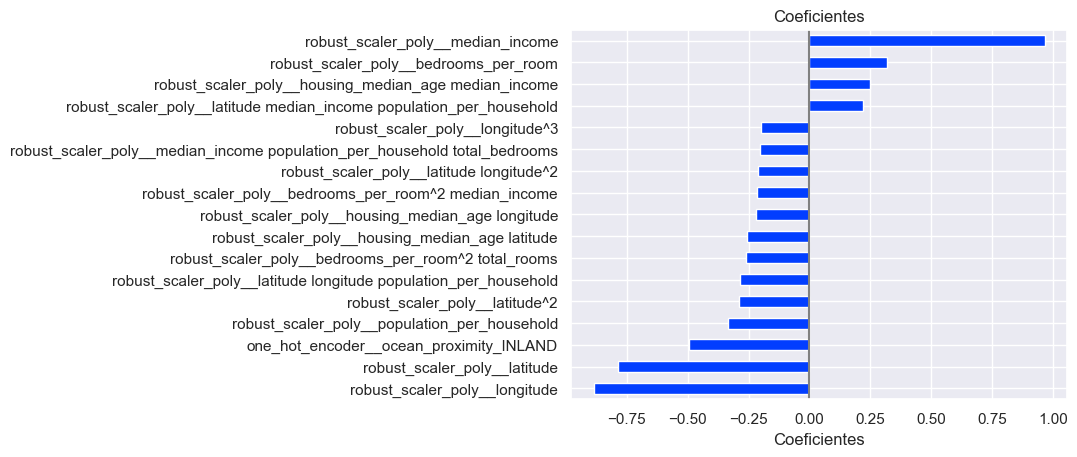

In [15]:
# somente os coeficientes mais relevantes
plot_coeficientes(coefs[~coefs['coeficiente'].between(-0.2,0.2)])

Os coeficientes com maior relevância são a renda média e localização, o que é bastante coerente. Vamos testar a eficácia do modelo

In [16]:
regressors = {
    "DummyRegressor" : {
        "preprocessor" : None,
        "regressor" : DummyRegressor(strategy='mean'),
        "target_transformer" : None,
    },
        "LinearRegression" : {
        "preprocessor" : preprocessamento,
        "regressor" : LinearRegression(),
        "target_transformer" : None,
    },
        "LinearRegression_target_quantile" : {
        "preprocessor" : preprocessamento,
        "regressor" : LinearRegression(),
        "target_transformer" : QuantileTransformer(output_distribution='normal'),
    },
        "LinearRegression_target_quantile_poly" : {
        "preprocessor" : grid_search.best_estimator_.regressor_['preprocessor'],
        "regressor" : LinearRegression(),
        "target_transformer" : QuantileTransformer(output_distribution='normal'),
    },

        "Ridge_grid_search" : {
        "preprocessor" : grid_search.best_estimator_.regressor_['preprocessor'],
        "regressor" : grid_search.best_estimator_.regressor_['reg'],
        "target_transformer" : grid_search.best_estimator_.transformer_,
    },

}

resultados = {
    nome_modelo : treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.0,0.010574,-0.000081,-77516.042766,-96239.705692,0.010574
1,DummyRegressor,0.002494,0.006633,-0.000146,-75787.787194,-95217.629397,0.009127
2,DummyRegressor,0.0,0.0,-0.001737,-76753.598961,-96253.253947,0.0
3,DummyRegressor,0.003457,0.0,-0.000101,-76837.804811,-95983.885799,0.003457
4,DummyRegressor,0.0,0.013193,-0.000114,-76617.245449,-96182.764729,0.013193
5,LinearRegression,0.049232,0.0,0.682162,-39855.690996,-54254.958188,0.049232
6,LinearRegression,0.019139,0.016728,0.66999,-40272.565467,-54695.230283,0.035867
7,LinearRegression,0.032535,0.017294,0.649247,-42178.05929,-56955.988706,0.049829
8,LinearRegression,0.033631,0.015623,0.669873,-40806.492497,-55146.318803,0.049254
9,LinearRegression,0.016632,0.015634,0.669023,-40788.496497,-55331.35106,0.032266


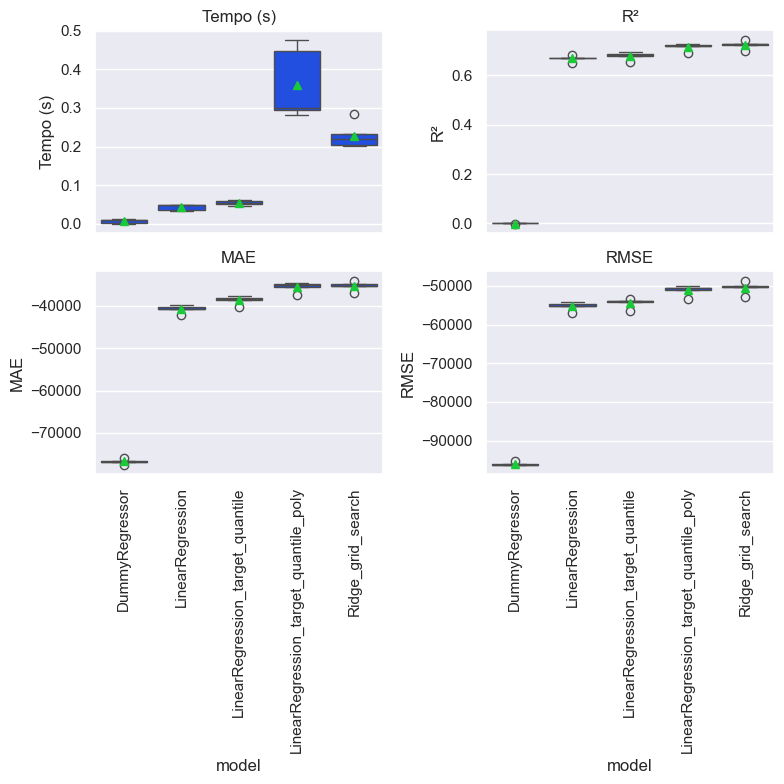

In [17]:
plot_comparar_metricas_modelos(df_resultados)

Ridge é bem melhor que elastic net e diminuiu o tempo do Linear Regression diminuindo um pouco o erro

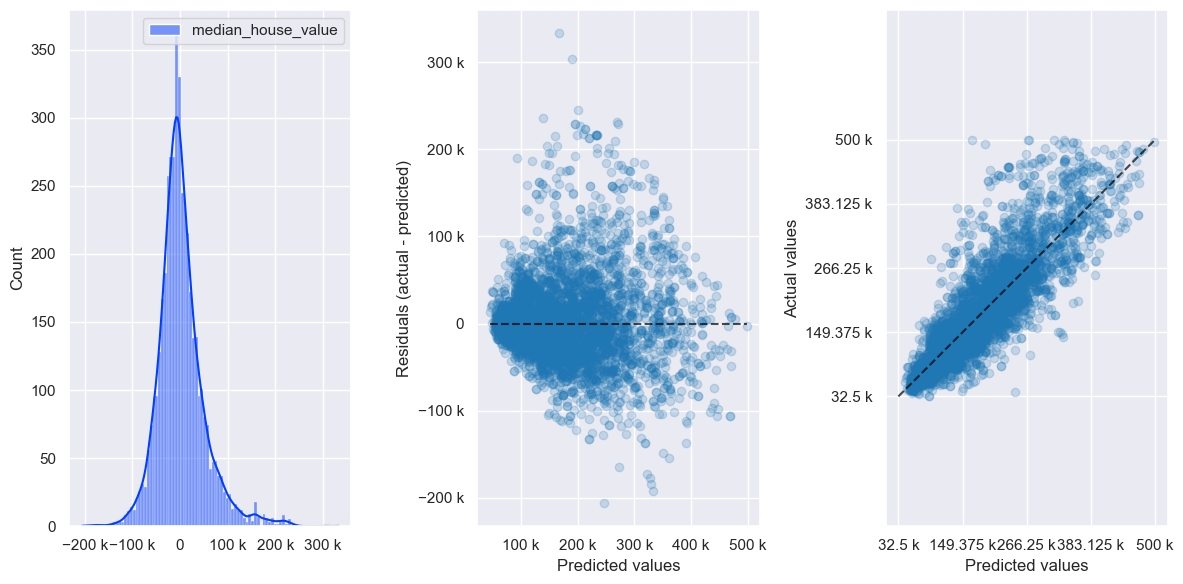

In [ ]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, eng_formatter=True, 
                        caminho_fig=f'{PASTA_IMAGENS}/5_residuos_modelo_final.png')

A maior frequência de resíduo próximo a zero nos testes mostra a eficácia do modelo. Os erros maiores ocorrem para casas mais caras, com erro para menos (valor real maior que o previsto para os maiores erros). Isso acontece pois temos mais registros na base com casas de menor a médio preço do que de preços exorbitantes, como é possível notar nos 2 gráficos a direita.

Comparando com o resultado anterior, resultado similar ao Elastic Net com leve redução do erro.

# Exportar o modelo

Temos o modelo final, falta apenas exportar para se usado em nosso aplicativo.

In [19]:
# dump(value=grid_search.best_params_, filename=f'{PASTA_MODELOS}/ridge_polyfeat_target_quantile.joblib')